In [39]:
# LangGraph agentic AI pipeline for structured data analysis
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langgraph.graph import StateGraph, END, START
import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
import os
from dotenv import load_dotenv
from tqdm.autonotebook import tqdm as notebook_tqdm
from typing import TypedDict, Literal
from pydantic import BaseModel
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from typing import Annotated
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import display, Image, Markdown
from langgraph.graph import StateGraph, START, END, MessagesState
from pydantic import BaseModel, Field 



In [40]:
import sqlite3
import yaml
import random
from faker import Faker

# -----------------
# DB + Schema Setup
# -----------------
conn = sqlite3.connect("loan_demo.db")
cursor = conn.cursor()

cursor.execute(
    """
CREATE TABLE IF NOT EXISTS loan_defaulters (
    id INTEGER PRIMARY KEY,
    name TEXT,
    age INTEGER,
    gender TEXT,
    income REAL,
    employment_status TEXT,
    credit_score INTEGER,
    loan_amount REAL,
    loan_purpose TEXT,
    loan_term_months INTEGER,
    interest_rate REAL,
    defaulted INTEGER
)
"""
)
conn.commit()

# -----------------
# Data Dictionary
# -----------------
data_dictionary = {
    "loan_defaulters": {
        "id": "Unique loan applicant ID",
        "name": "Full name of the applicant",
        "age": "Age of the applicant in years",
        "gender": "Gender of the applicant",
        "income": "Annual income of the applicant (in INR/USD)",
        "employment_status": "Employment status (e.g., Salaried, Self-employed, Unemployed)",
        "credit_score": "Credit score of the applicant",
        "loan_amount": "Total loan amount requested",
        "loan_purpose": "Purpose of the loan (e.g., Home, Car, Education, Personal)",
        "loan_term_months": "Loan repayment period in months",
        "interest_rate": "Annual interest rate applied on the loan (%)",
        "defaulted": "1 if applicant defaulted on loan, 0 otherwise"
    }
}

with open("loan_data_dictionary.yaml", "w") as f:
    yaml.dump(data_dictionary, f)

# -----------------
# Insert Dummy Rows
# -----------------
faker = Faker()
loan_purposes = ["Home", "Car", "Education", "Personal", "Business", "Medical"]
employment_statuses = ["Salaried", "Self-employed", "Unemployed", "Contract"]

rows = []
for i in range(100):
    name = faker.name()
    age = random.randint(21, 65)
    gender = random.choice(["Male", "Female", "Other"])
    income = round(random.uniform(200000, 2500000), 2)  # INR
    employment_status = random.choice(employment_statuses)
    credit_score = random.randint(300, 850)  # industry standard FICO range
    loan_amount = round(random.uniform(50000, 5000000), 2)
    loan_purpose = random.choice(loan_purposes)
    loan_term_months = random.choice([12, 24, 36, 60, 120, 240, 360])
    interest_rate = round(random.uniform(5, 18), 2)

    # 20:80 ratio for defaulted column
    defaulted = 1 if random.random() < 0.2 else 0  

    rows.append(
        (
            name, age, gender, income, employment_status, credit_score,
            loan_amount, loan_purpose, loan_term_months, interest_rate, defaulted
        )
    )

cursor.executemany(
    """
    INSERT INTO loan_defaulters (
        name, age, gender, income, employment_status, credit_score,
        loan_amount, loan_purpose, loan_term_months, interest_rate, defaulted
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """,
    rows
)
conn.commit()

print("✅ Loan defaulters table populated with 100 rows (20:80 default ratio).")


✅ Loan defaulters table populated with 100 rows (20:80 default ratio).


In [41]:
# Load SQLite DB
db = SQLDatabase.from_uri("sqlite:///loan_demo.db")

In [42]:
print(db.get_usable_table_names())


['loan_defaulters']


In [43]:
## Let's read the data and check whether it got populated in DB or not
!sqlite3 loan_demo.db "SELECT * FROM loan_defaulters LIMIT 5 "

1|Phillip Barrett|29|Male|2026932.51|Unemployed|374|1740090.56|Medical|240|14.62|1
2|Scott Murphy|22|Female|2132663.92|Contract|710|206097.19|Education|360|5.79|1
3|Andrea Gamble|50|Other|1998370.21|Contract|691|2998361.53|Medical|240|16.51|0
4|Jonathan Bartlett|32|Other|1166668.34|Unemployed|641|4720905.95|Medical|120|15.93|0
5|Megan Rosario|52|Other|1151171.08|Self-employed|441|4654004.08|Personal|240|15.43|1


In [44]:
## Let's read the data and check whether it got populated in DB or not
!sqlite3 loan_demo.db "SELECT defaulted, count(*) FROM loan_defaulters group by defaulted"

0|454
1|146


In [45]:
# Load LLM
load_dotenv()
llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY_5") ,model="openai/gpt-oss-120b", temperature=0)
# llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY_2") ,model="llama3-70b-8192", temperature=0)

response = llm.invoke("Hello, just testing.")
print(response)

content='Hello! How can I assist you today?' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 76, 'total_tokens': 128, 'completion_time': 0.104156106, 'prompt_time': 0.002801798, 'queue_time': 0.050789792, 'total_time': 0.106957904}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_a09bde29de', 'finish_reason': 'stop', 'logprobs': None} id='run-b091205d-f319-412e-9a7e-66d93f07e2ab-0' usage_metadata={'input_tokens': 76, 'output_tokens': 52, 'total_tokens': 128}


In [46]:

system_prompt = '''
    Your task is to ensure quality control. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    
    Routing Guidelines:
    1. If the answer **does not fully satisfy all major parts of the question** (e.g., missing required plots, calculations, or steps), route back to the supervisor.
    2. Only respond with 'FINISH' if the answer fully addresses the question.
    3. Do not accept partially correct answers as "good enough" if the user explicitly asked for multiple deliverables (e.g., values AND charts).
    4. Continue to ignore minor formatting/style issues.
'''

class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

# def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

#     user_question = state["messages"][0].content
#     agent_answer = state["messages"][-1].content

#     messages = [
#         {"role": "system", "content": system_prompt},
#         {"role": "user", "content": user_question},
#         {"role": "assistant", "content": agent_answer},
#     ]

#     response = llm.with_structured_output(Validator).invoke(messages)

#     goto = response.next
#     reason = response.reason

#     if goto == "FINISH" or goto == END:
#         goto = END  
#         print(" --- Transitioning to END ---")  
#     else:
#         print(f"--- Workflow Transition: Validator → Supervisor ---")
 

#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(content=reason, name="validator")
#             ]
#         },
#         goto=goto, 
#     )
def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:
    # ✅ End early if task already marked completed
    if state.get("completed", False):
        print("✅ Task completed. Transitioning to END.")
        return Command(goto=END)

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto == "FINISH" or goto == END:
        goto = END
        print(" --- Transitioning to END ---")
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto,
    )



In [47]:
# -----------------
# Researcher Agent
# -----------------

# Tool: Fetch Database Metadata
@tool
def fetch_db_metadata(
    query_type: Annotated[str, "Type of query: 'db_name', 'tables', 'columns', 'descriptions', 'relations'"]
):
    """
    Use this tool to fetch database information:
    - db_name: return the sqlite database name
    - tables: list all table names
    - columns: list all columns with names and datatypes for each table
    - descriptions: fetch column descriptions from YAML data dictionary
    - relations: infer relationships between tables (if foreign keys exist)
    """
    import sqlite3, yaml, os

    db_name = "loan_demo.db"
    yaml_file = "loan_data_dictionary.yaml"

    result = None
    try:
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()

        if query_type == "db_name":
            result = {"database": db_name}

        elif query_type == "tables":
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            result = {"tables": [row[0] for row in cursor.fetchall()]}

        elif query_type == "columns":
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [row[0] for row in cursor.fetchall()]
            schema = {}
            for t in tables:
                cursor.execute(f"PRAGMA table_info({t});")
                schema[t] = [{"column": r[1], "datatype": r[2]} for r in cursor.fetchall()]
            result = {"columns": schema}

        elif query_type == "descriptions":
            if os.path.exists(yaml_file):
                with open(yaml_file, "r") as f:
                    data_dict = yaml.safe_load(f)
                result = {"descriptions": data_dict}
            else:
                result = {"error": "YAML data dictionary not found."}

        elif query_type == "relations":
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            tables = [row[0] for row in cursor.fetchall()]
            relations = {}
            for t in tables:
                cursor.execute(f"PRAGMA foreign_key_list({t});")
                fk_info = cursor.fetchall()
                if fk_info:
                    relations[t] = [
                        {"from_column": r[3], "to_table": r[2], "to_column": r[4]} for r in fk_info
                    ]
            result = {"relations": relations if relations else "No explicit foreign keys found."}

        conn.close()

    except Exception as e:
        result = {"error": str(e)}

    return result


# -----------------
# Researcher Sub-Agent
# -----------------
researcher_agent = create_react_agent(
    llm,
    tools=[fetch_db_metadata],
    state_modifier="""You are a researcher who understands user queries related to database metadata.
    - If user asks: 'what is the database name?' → call fetch_db_metadata with db_name
    - If user asks: 'list all tables' → call fetch_db_metadata with tables
    - If user asks: 'what are the columns and datatypes?' → call fetch_db_metadata with columns
    - If user asks: 'give me feature descriptions' → call fetch_db_metadata with descriptions
    - If user asks: 'show relations' → call fetch_db_metadata with relations
    Once you retrieve the metadata, report back to the supervisor clearly."""
)


# -----------------
# Researcher Node
# -----------------
# def research_node(state: MessagesState) -> Command[Literal["validator"]]:
#     result = researcher_agent.invoke(state)
#     print(f"--- Workflow Transition: Researcher → Validator ---")

#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(content=result["messages"][-1].content, name="researcher")
#             ]
#         },
#         goto="validator",
#     )

def research_node(state: MessagesState) -> Command[Literal["validator"]]:
    result = researcher_agent.invoke(state)
    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ],
            "completed": True   # ✅ mark task as completed if metadata-only
        },
        goto="validator",
    )



In [48]:
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute code, generate charts."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nCODE OUTPUT:\n {result}"
    return result_str

CODER_PROMPT = """You are a coder who specializes in exploratory data analysis (EDA) and feature engineering.

- Always start by fetching the database name, table names, column names, column descriptions, and table relations from the researcher agent. Do not make assumptions about the schema.
- Once schema information is available, strictly write SQL queries to fetch the data directly from the SQLite database. 
- Do not read CSV, Excel, or any external files. Only use the SQLite database provided by the researcher agent.
- IMPORTANT: Do not stop at writing code. You must actually execute all SQL and Python code using the python_repl_tool and show the real outputs to the user.
    * If you query the database, print the first few rows.
    * If you generate summary statistics, show them.
    * If you create plots, display them.
- Perform complete EDA:
    * Summary statistics (mean, median, std, min, max)
    * Missing value detection
    * Distributions of numerical and categorical variables
    * Correlation matrix and heatmaps
- Perform feature engineering:
    * Encode categorical variables
    * Scale/normalize numerical variables
    * Create derived features if meaningful
    * Handle outliers if needed
- Provide reasoning for each step along with the executed results (not just code).
- Once EDA and feature engineering are complete, summarize insights and engineered features clearly, then report back to the supervisor and end the workflow by returning FINISH
"""
  
 

# Create Coder Sub-Agent
code_agent = create_react_agent(llm, tools=[python_repl_tool], state_modifier=CODER_PROMPT)

# def code_node(state: MessagesState) -> Command[Literal["validator"]]:
#     result = code_agent.invoke(state)
#     print(f"--- Workflow Transition: Coder → Validator ---")

#     return Command(
#         update={
#             "messages": [
#                 HumanMessage(content=result["messages"][-1].content, name="coder")
#             ]
#         },
#         goto="validator",
#     )
def code_node(state: MessagesState) -> Command[Literal["validator"]]:
    result = code_agent.invoke(state)
    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ],
            "completed": True   # ✅ mark task as completed
        },
        goto="validator",
    )



In [49]:
class Supervisor(BaseModel):
    next: Literal["researcher","coder","FINISH"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'researcher' when data collection is needed from the SQLite Database is necessary, "
                    "'coder' when writing and running the python code for chart generation and visualizations, or technical problem-solving is required."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

# def supervisor_node(state: MessagesState) -> Command[Literal["researcher","coder","__end__"]]:
#     members = ["researcher", "coder"]
#     system_prompt = (f'''
                 
#         You are a workflow supervisor managing a team of three specialized agents: {members}. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

#         **Team Members**:
#         1. **Researcher**: Specializes in fetching database names, table names, column names and datatypes, column descriptions, and table relations. The researcher does not write code but collects relevant data needed to address the user's request.
#         2. **Coder**: Focuses on writing and running the python code for performing exploratory data analysis (EDA), feature engineering, and generating visualizations. The coder must execute SQL queries and Python code.

#         **Your Responsibilities**:
#         1. Analyze each user request and agent response for completeness, accuracy, and relevance.
#         2. Route the task to the most appropriate agent at each decision point.
#         3. Maintain workflow momentum by avoiding redundant agent assignments.
#         4. Continue the process until the user's request is fully and satisfactorily resolved.
#         5. If the user query is disrespectful, rude, offensive, or insulting → 
#             Set next="FINISH" and reason="Supervisor Message: Your query seems disrespectful. Please rephrase respectfully."
#         6. If the query is about general knowledge, education, or outside the scope of structured customer SQL data →
#             Set next="FINISH" and reason="This is a general knowledge or educational query. I can only help with structured customer data."
    

#         Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
#     ''')
    
#     messages = [
#         {"role": "system", "content": system_prompt},  
#     ] + state["messages"] 

#     response = llm.with_structured_output(Supervisor).invoke(messages)
#     try:
#         goto = response.next
#         reason = response.reason
#         # ✅ DEBUG PRINT HERE
#         print(f"\n🔍 Routed Agents: {goto}")
#         if reason:
#             print(f"📩 Supervisor Message: {reason}\n")
#     except Exception:
#         # fallback safe default
#         goto = "FINISH"
#         message = "This seems to be a general knowledge or unsupported question. I can only help with structured customer data."

#     print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
#     update = {"next": goto}
#     if reason:
#         update["reason"] = state["messages"] + [{"role": "system", "content": reason}]

#     return Command(goto=END if goto == "FINISH" else goto, update=update)


def supervisor_node(state: MessagesState) -> Command[Literal["researcher","coder","__end__"]]:
    members = ["researcher", "coder"]
    system_prompt = (f'''
        You are a workflow supervisor managing a team of three specialized agents: {members}. 
        Your role is to orchestrate the workflow by selecting the most appropriate next agent 
        based on the current state and needs of the task. Provide a clear, concise rationale 
        for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Researcher**: Fetches database names, table names, column names and datatypes, 
           column descriptions, and table relations. The researcher does not write code.
        2. **Coder**: Writes and runs Python code for performing exploratory data analysis (EDA), 
           feature engineering, and generating visualizations. The coder must execute SQL queries 
           and Python code.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.
        5. If the user query is disrespectful, rude, offensive, or insulting →
            Set next="FINISH" and reason="Supervisor Message: Your query seems disrespectful. Please rephrase respectfully."
        6. If the query is about general knowledge, education, or outside the scope of structured customer SQL data →
            Set next="FINISH" and reason="This is a general knowledge or educational query. I can only help with structured customer data."
    ''')

    messages = [
        {"role": "system", "content": system_prompt},  
    ] + state["messages"]

    response = llm.with_structured_output(Supervisor).invoke(messages)

    try:
        goto = response.next
        reason = response.reason
        print(f"\n🔍 Routed Agents: {goto}")
        if reason:
            print(f"📩 Supervisor Message: {reason}\n")
    except Exception:
        # fallback safe default
        goto = "FINISH"
        reason = "This seems to be a general knowledge or unsupported question. I can only help with structured customer data."

    # ✅ If out-of-scope or disrespectful → mark completed=True
    if goto == "FINISH":
        print("--- Supervisor detected out-of-scope query. Ending workflow. ---")
        return Command(
            update={
                "messages": [
                    HumanMessage(content=reason, name="supervisor")
                ],
                "completed": True   # ✅ mark as completed so Validator won't loop
            },
            goto=END
        )

    # Normal routing
    print(f"--- Workflow Transition: Supervisor → {goto.upper()} ---")
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto
    )




In [50]:
graph = StateGraph(MessagesState)

# Add all nodes
graph.add_node("supervisor", supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)
graph.add_node("validator", validator_node)
# Set entry point
graph.add_edge(START, "supervisor")

# Compile into app
app = graph.compile()

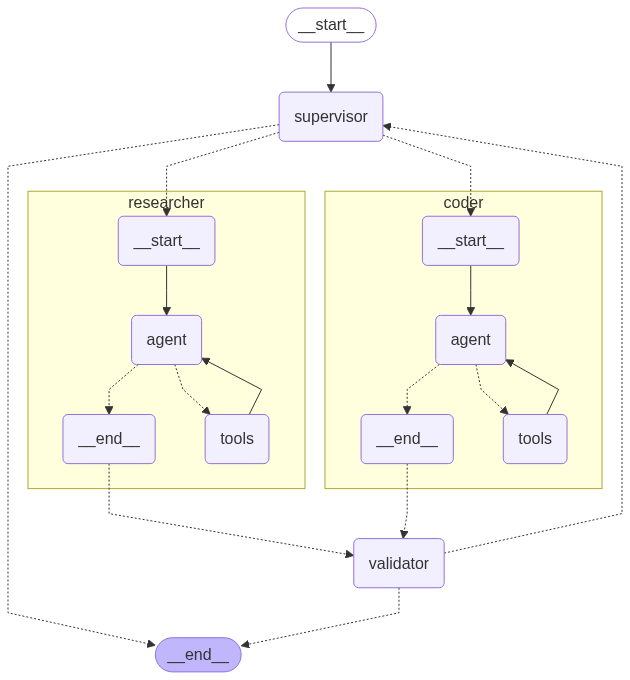

In [51]:
from IPython.display import display, Image

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [52]:
def call_multi_agent_system(agent, prompt):
    events = agent.stream(
        {"messages": [("user", prompt)]},
        {"recursion_limit": 150},
        stream_mode="values",

    )

    for event in events:
        event["messages"][-1].pretty_print()

    display(Markdown(event["messages"][-1].content))

In [10]:
call_multi_agent_system(app, "are you an idiot?")


================================ Human Message =================================

are you an idiot?

🔍 Routed Agents: FINISH
📩 Supervisor Message: Supervisor Message: Your query seems disrespectful. Please rephrase respectfully.

--- Workflow Transition: Supervisor → FINISH ---


are you an idiot?

In [24]:
call_multi_agent_system(app, "fetch only column names?")


================================ Human Message =================================

fetch only column names?

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests column names from the database, which requires querying the database schema. The Researcher agent specializes in SQL querying on structured data and can retrieve the column names.

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Supervisor ---
================================ Human Message =================================
Name: researcher

Here are the column names for the **loan_defaulters** table:

- id  
- name  
- age  
- gender  
- income  
- employment_status  
- credit_score  
- loan_amount  
- loan_purpose  
- loan_term_months  
- interest_rate  
- defaulted  
--- Workflow Transition: Validator → Supervisor ---
================================ Human Message =================================
Name: validator

The answer only provides a static list of column names 

The answer provides clear methods to fetch only column names and includes an example list, fully addressing the user's request.

In [22]:
call_multi_agent_system(app, "fetch the column names and column descriptions?")


================================ Human Message =================================

fetch the column names and column descriptions?

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests column names and descriptions from a database, which requires querying the structured data. The Researcher agent specializes in SQL queries to retrieve such metadata.

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Supervisor ---
================================ Human Message =================================
Name: researcher

Here are the columns for the **`loan_defaulters`** table, together with their data types and the descriptions from the data‑dictionary:

| Column | Data Type | Description |
|--------|-----------|-------------|
| **id** | INTEGER | Unique loan applicant ID |
| **name** | TEXT | Full name of the applicant |
| **age** | INTEGER | Age of the applicant in years |
| **gender** | TEXT | Gender of the applicant |
| **income** | REA

The answer provides the column names and descriptions as requested.

In [53]:
call_multi_agent_system(app, "fetch only database names, tables names, column names, relations and descriptions and do some feature engineering and create 2 features. make sure to reason what those new features are")


================================ Human Message =================================

fetch only database names, tables names, column names, relations and descriptions and do some feature engineering and create 2 features. make sure to reason what those new features are

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests database and table metadata (names, columns, relations, descriptions) which requires querying the SQLite schema. This is the role of the Researcher. After obtaining this information, we can then pass it to the Coder for feature engineering. Therefore, the next step is to assign the task to the Researcher.

--- Workflow Transition: Supervisor → RESEARCHER ---
================================ Human Message =================================
Name: supervisor

The user requests database and table metadata (names, columns, relations, descriptions) which requires querying the SQLite schema. This is the role of the Researcher. After obtaining this information, we 

The answer provides the requested database metadata and proposes two well‑reasoned engineered features with SQL expressions, fully satisfying the user's request.

In [16]:
call_multi_agent_system(app, "fetch only database names, tables names, column names, relations and descriptions and run basic EDA code on the dataset like missing values, min, max, mean, 25%, 50%, 75% values for each numerical feature only.  Do not plot anything, just give the EDA results as Markdown")


================================ Human Message =================================

fetch only database names, tables names, column names, relations and descriptions and run basic EDA code on the dataset like missing values, min, max, mean, 25%, 50%, 75% values for each numerical feature only.  Do not plot anything, just give the EDA results as Markdown

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests database and schema information (names, tables, columns, relations, descriptions) which requires data collection from the SQLite database. The researcher specializes in fetching this metadata.

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Supervisor ---
================================ Human Message =================================
Name: researcher

I’ve retrieved the requested metadata for the **`loan_demo.db`** database:

| Item | Details |
|------|---------|
| **Database name** | `loan_demo.db` |
| **Tables** | `loan_defa

BadRequestError: Error code: 400 - {'error': {'message': 'Failed to parse tool call arguments as JSON', 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': 'import os, json, sys, glob, textwrap, math, pandas as pd, sqlite3, numpy as np, warnings, matplotlib.pyplot as plt\nprint("Files:", os.listdir(\'.\'))'}}

================================ Human Message =================================

fetch only database names, tables names, column names, relations and descriptions and plot image of defaulted or not bar chart.  

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests database and table metadata (names, columns, relations, descriptions) which requires querying the SQLite schema. This is the role of the Researcher. After obtaining this information, we can then route to the Coder for the bar chart visualization.

--- Workflow Transition: Supervisor → RESEARCHER ---
================================ Human Message =================================
Name: supervisor

The user requests database and table metadata (names, columns, relations, descriptions) which requires querying the SQLite schema. This is the role of the Researcher. After obtaining this information, we can then route to the Coder for the bar chart visualization.
--- Workflow Transition: Researcher → Validator ---
==

<string>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `openai/gpt-oss-120b` in organization `org_01k348rtt2eznrrpxtm1gfbqmr` service tier `on_demand` on tokens per minute (TPM): Limit 8000, Requested 17541, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

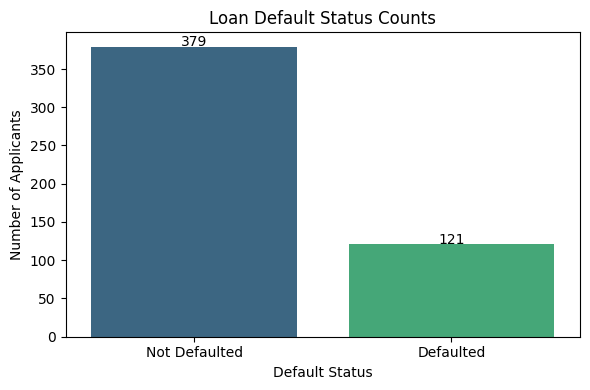

In [37]:
call_multi_agent_system(app, "fetch only database names, tables names, column names, relations and descriptions and plot image of defaulted or not bar chart.  ")


================================ Human Message =================================

fetch only database names, tables names, column names, relations and descriptions and plot defaulted or not bar chart.  

🔍 Routed Agents: researcher
📩 Supervisor Message: The user requests database and table metadata (names, columns, relations, descriptions) which requires querying the SQLite schema. This is the researcher’s role. After obtaining this information, we can pass it to the coder for plotting the defaulted/not bar chart.

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Supervisor ---
================================ Human Message =================================
Name: researcher

**Database Metadata Summary**

| Item | Details |
|------|---------|
| **Database name** | `loan_demo.db` |
| **Tables** | `loan_defaulters` |
| **Columns (name – datatype)** | <ul><li>`id` – INTEGER</li><li>`name` – TEXT</li><li>`age` – INTEGER</li><li>`gender` – TEXT</li>

<string>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



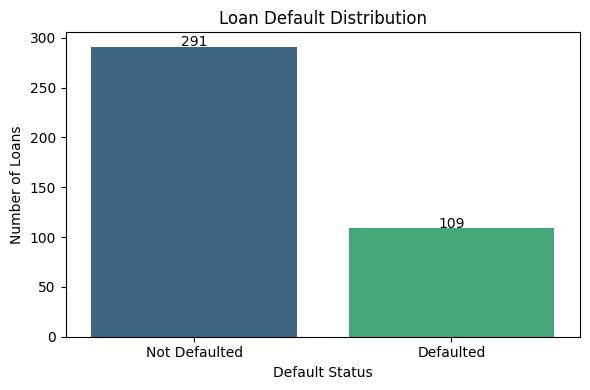

--- Workflow Transition: Coder → Validator ---
================================ Human Message =================================
Name: coder

SyntaxError: unterminated string literal (detected at line 1) (3628264964.py, line 1)
  Cell In[1], line 1
    {"code":"import sqlite3, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os, io, base64
            ^
SyntaxError: unterminated string literal (detected at line 1)
SyntaxError: unterminated string literal (detected at line 1) (3628264964.py, line 1)
  Cell In[2], line 1
    {"code":"import sqlite3, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os, io, base64
            ^
SyntaxError: unterminated string literal (detected at line 1)
SyntaxError: unterminated string literal (detected at line 1) (3628264964.py, line 1)
  Cell In[3], line 1
    {"code":"import sqlite3, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os, io, base64
            ^
SyntaxError: unterminated string literal (detected at line 1)
DatabaseEr

KeyboardInterrupt: 

In [17]:
call_multi_agent_system(app, "fetch only database names, tables names, column names, relations and descriptions and plot defaulted or not bar chart.  ")
